# TESTs

## Devices

In [1]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cpu')

## Test training model

Estimated train time : 11.0h 42.0m 0.0
--> Running on the CPU
Model loaded from ./trained_models/local/0\model.pth
INFO - Step 33184, rl-loss: 0.006385975982993841
----------------------------------------
  episode      |  0
  reward       |  0.021
----------------------------------------
INFO - Step 34100, rl-loss: 0.0051717064343392855
INFO - Copied model parameters to target network.
INFO - Step 35100, rl-loss: 0.0117062181234359745
INFO - Copied model parameters to target network.
INFO - Step 36100, rl-loss: 0.2128457129001617415
INFO - Copied model parameters to target network.
INFO - Step 36384, rl-loss: 0.1031341999769210895
----------------------------------------
  episode      |  100
  reward       |  0.034
----------------------------------------
INFO - Step 37100, rl-loss: 0.4363656640052795424
INFO - Copied model parameters to target network.
INFO - Step 38100, rl-loss: 0.0058797476813197145
INFO - Copied model parameters to target network.
INFO - Step 39100, rl-loss: 0.10

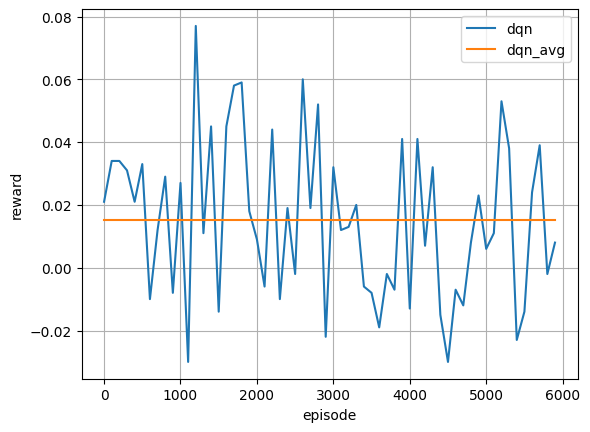

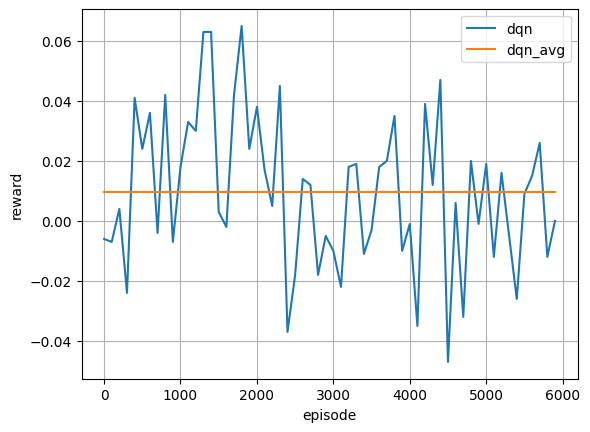

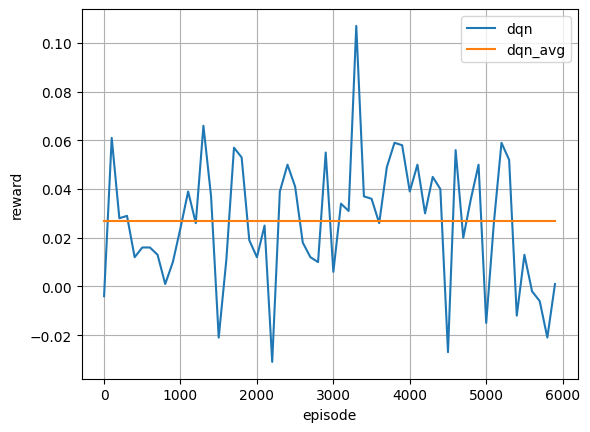

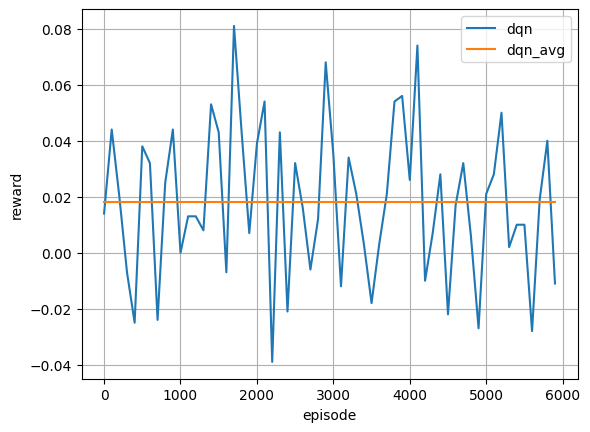

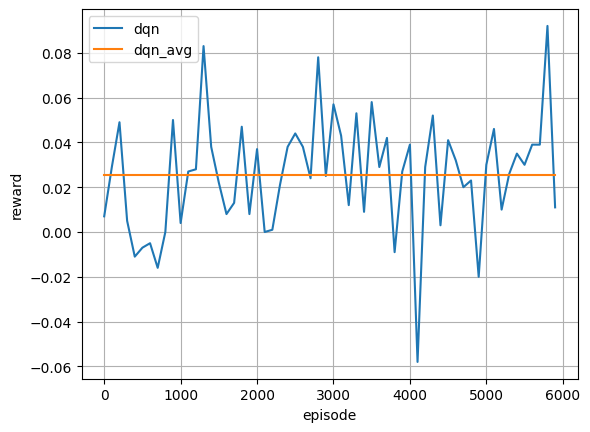

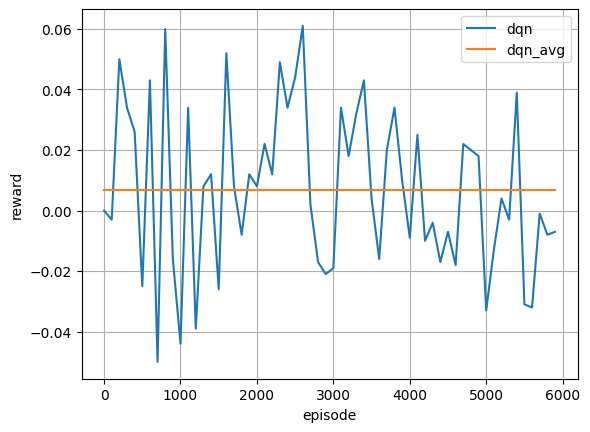

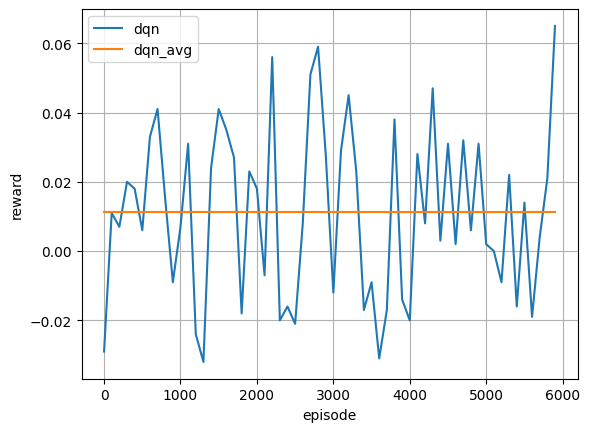

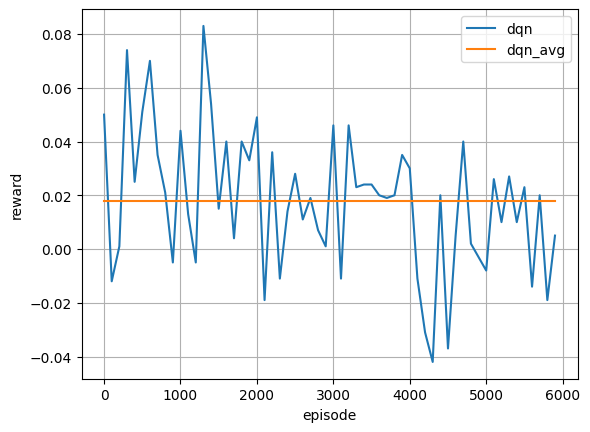

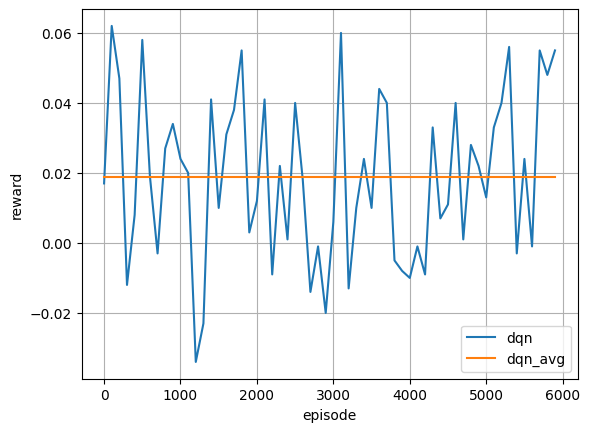

In [17]:
from SmartCardAI import train
import os

basic_size = 32
layer_architectures = ([1, 1],      # 0
                    [2, 2],         # 1
                    [3, 3],         # 2
                    [1, 1, 1],      # 3
                    [1, 1, 1, 1],   # 4
                    [1, 2, 1],      # 5
                    [2, 3, 2],      # 6
                    [3, 2, 1],      # 7
                    [1, 2, 3])      # 8

layer_architectures = tuple([e * basic_size for e in layer_type] for layer_type in layer_architectures)

resume = True

train_time={'heure': 1,
            'minute': 5,
            'seconde': 0}

train_time = train_time['heure'] * 3600 + train_time['minute'] * 60 + train_time['seconde']

estimated_train_time = train_time * 1.2 * len(layer_architectures)
print(f'Estimated train time : {estimated_train_time//3600}h {estimated_train_time%3600//60}m {estimated_train_time%3600%60}')

for i, layers in enumerate(layer_architectures[0:]):
    train(env_type='uno', algorithm='dqn', seed=42, num_episodes=6000, dir=fr'./trained_models/local/{i}', mlp_layers=layers, resume_training=[None,'model.pth'][os.path.exists(fr'./trained_models/local/{0}/model.pth') and resume], learning_rate=0.05, max_time=train_time) #


Estimated train time : 0.0h 54.0m 0.0
--> Running on the CPU
--> Running on the CPU
--> Running on the CPU
--> Running on the CPU
--> Running on the CPU
--> Running on the CPU
--> Running on the CPU
--> Running on the CPU
--> Running on the CPU
Model loaded from ./trained_models/local/1\model.pth
Model loaded from ./trained_models/local/5\model.pth
Model loaded from ./trained_models/local/2\model.pth
Model loaded from ./trained_models/local/7\model.pth


d:\Personnel\School\IUT3\ia\SmartCardAI\__init__.py:171: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  agents.append(torch.load(pretrained_model_path))


Model loaded from ./trained_models/local/6\model.pth
Model loaded from ./trained_models/local/3\model.pth
Model loaded from ./trained_models/local/8\model.pth
Model loaded from ./trained_models/local/4\model.pth
Model loaded from ./trained_models/local/0\model.pth

----------------------------------------
  episode      |  0
  reward       |  0.127
----------------------------------------
INFO - Step 225172, rl-loss: 0.030094960704445847
Logs saved in ./trained_models/local/0

----------------------------------------
  episode      |  0
  reward       |  0.088
----------------------------------------
INFO - Step 220781, rl-loss: 0.019363420084118843
Logs saved in ./trained_models/local/1

----------------------------------------
  episode      |  0
  reward       |  0.074
----------------------------------------
INFO - Step 219580, rl-loss: 0.028458913788199425
Logs saved in ./trained_models/local/6

----------------------------------------
  episode      |  0
  reward       |  0.068
-

TypeError: can't convert np.ndarray of type numpy.str_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint64, uint32, uint16, uint8, and bool.

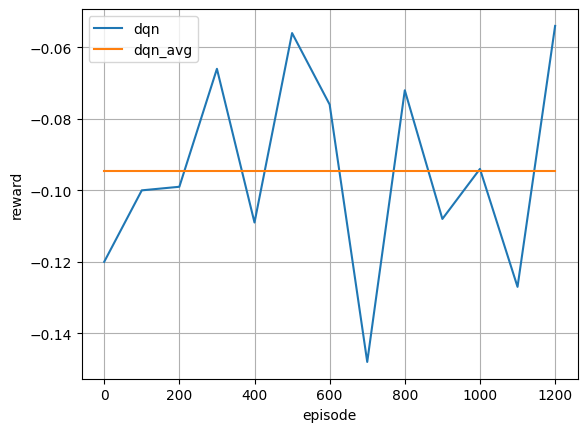

In [5]:
from SmartCardAI import train
import os
from concurrent.futures import ThreadPoolExecutor

basic_size = 32
layer_architectures = ([1, 1],      # 0
                    [2, 2],         # 1
                    [3, 3],         # 2
                    [1, 1, 1],      # 3
                    [1, 1, 1, 1],   # 4
                    [1, 2, 1],      # 5
                    [2, 3, 2],      # 6
                    [3, 2, 1],      # 7
                    [1, 2, 3])      # 8

layer_architectures = tuple([e * basic_size for e in layer_type] for layer_type in layer_architectures)

resume = True

train_time={'heure': 0,
            'minute': 5,
            'seconde': 0}

train_time = train_time['heure'] * 3600 + train_time['minute'] * 60 + train_time['seconde']

estimated_train_time = train_time * 1.2 * len(layer_architectures)
print(f'Estimated train time : {estimated_train_time//3600}h {estimated_train_time%3600//60}m {estimated_train_time%3600%60}')

def train_model(i, layers):
    train(env_type='uno', algorithm='dqn', seed=42, num_episodes=6000, dir=fr'./trained_models/local/{i}', mlp_layers=layers, resume_training=[None,'model.pth'][os.path.exists(fr'./trained_models/local/{0}/model.pth') and resume], learning_rate=0.001, max_time=train_time)

with ThreadPoolExecutor() as executor:
    futures = [executor.submit(train_model, i, layers) for i, layers in enumerate(layer_architectures)]
    for future in futures:
        future.result()


comparaison

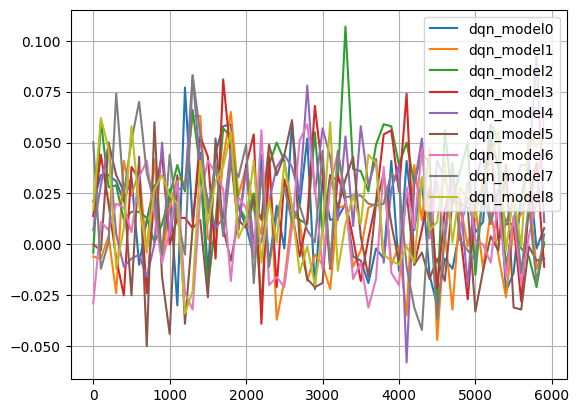

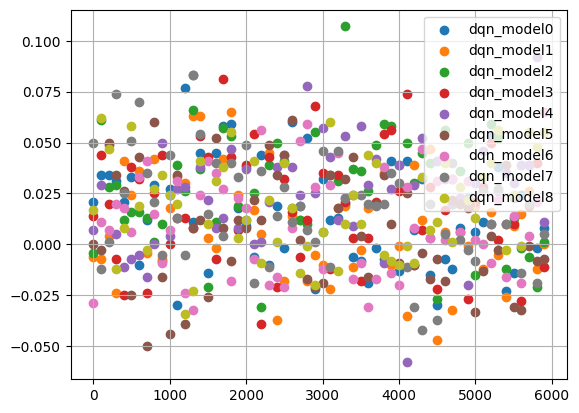

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

for i in range(len(layer_architectures)):
    dataset = pd.read_csv(f'./trained_models/local/{i}/performance.csv')

    plt.plot(dataset["episode"], dataset["reward"], label=f'dqn_model{i}')

plt.legend()
plt.grid()
plt.show()

for i in range(len(layer_architectures)):
    dataset = pd.read_csv(f'./trained_models/local/{i}/performance.csv')

    plt.scatter(dataset["episode"], dataset["reward"], label=f'dqn_model{i}')

plt.legend()
plt.grid()
plt.show()

## Evaluate some agents

In [7]:
from rlcard.models.uno_rule_models import UNORuleModelV1
from SmartCardAI.agents.rule_agents import UNORuleModelV2
from SmartCardAI.agents.rule_agents import UNORuleModelV4
from rlcard.agents import RandomAgent
from rlcard import models
import torch
from SmartCardAI.utils import tournament, rank_agents

# Initialiser l'agent basé sur des règles
rule_agent_1 = UNORuleModelV1().agents[0]
rule_agent_2 = UNORuleModelV2().agents[0]
rule_agent_4 = UNORuleModelV4().agents[0] # not working

# Chargement d'un modèle DQN
load_checkpoint_path = "trained_models/local/0/model.pth"
dqn_agent=torch.load(load_checkpoint_path)

# Chargement d'un modèle CFR pré-entrainé
cfr_agent = models.load('leduc-holdem-cfr').agents[0]

# Initialisation d'un agent aléatoire
random_agent = RandomAgent(num_actions=61)

# Évaluer les agents sur "num_games" parties
dqn_agents = [torch.load(f"trained_models/local/{i}/model.pth")for i in range(9)]
agents = dqn_agents + [rule_agent_1, rule_agent_2, rule_agent_4, random_agent]

agents_names = [f"dqn_agent{i}" for i in range(9)] + ["rule_agent_1", "rule_agent_2", "rule_agent_4", "random_agent"]
num_games = 10000

print("Classement des agents :")
for i, (name_index, score) in enumerate(rank_agents(agents, num_games=num_games)):
    print(f"Rank {str(i).center(2)}: Agent {agents_names[name_index].center(max(map(len, agents_names)))} - Taux de victoires : {score:.2%}")

C:\Users\gcmpr\AppData\Local\Temp\ipykernel_4480\1853876426.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dqn_agent=torch.load(load_checkpoint_path)
C:\Users\gcmpr\Ap

Classement des agents :
Rank 0 : Agent rule_agent_2 - Taux de victoires : 53.85%
Rank 1 : Agent rule_agent_1 - Taux de victoires : 53.56%
Rank 2 : Agent rule_agent_4 - Taux de victoires : 50.11%
Rank 3 : Agent  dqn_agent1  - Taux de victoires : 50.07%
Rank 4 : Agent  dqn_agent4  - Taux de victoires : 50.03%
Rank 5 : Agent  dqn_agent2  - Taux de victoires : 49.79%
Rank 6 : Agent  dqn_agent6  - Taux de victoires : 49.78%
Rank 7 : Agent  dqn_agent3  - Taux de victoires : 49.30%
Rank 8 : Agent  dqn_agent5  - Taux de victoires : 49.01%
Rank 9 : Agent  dqn_agent0  - Taux de victoires : 48.95%
Rank 10: Agent  dqn_agent8  - Taux de victoires : 48.74%
Rank 11: Agent  dqn_agent7  - Taux de victoires : 48.55%
Rank 12: Agent random_agent - Taux de victoires : 48.24%


# Remind :

```shell
python3.12 SmartCardAI --env_type uno --algorithm dqn --num_episode 500 --dir trained_model/local --resume_training model.pth
```